In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing, Target Engineering and RNN model with Word2Vec embedding 
### on final Data Set from OpenAlex

In [3]:
# Reading Data
data = pd.read_csv('../raw_data/data_1k.csv')
data = data.drop(columns='Unnamed: 0')
data.head()

,id,title,text,topic,subtopic
0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


#### Data cleaning is not necessary, since we built this dataset ourselves.

## Preprocessing

In [4]:
# Lowercasing everything
data = data.apply(lambda x: x.astype(str).str.lower())

In [5]:
# Removing anything apart from lower case letters 
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

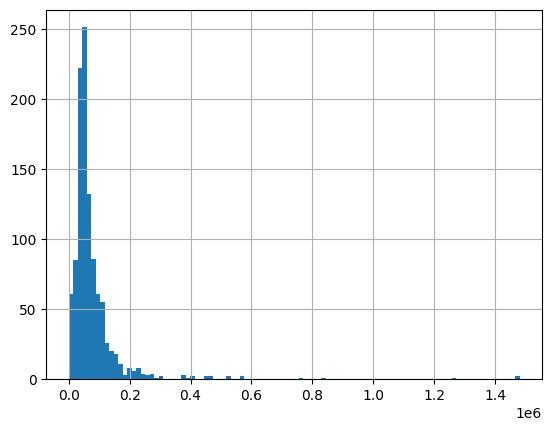

In [6]:
# This is the distribution of the total number of words per paper
data['total words per text'] = data['text'].apply(lambda x : len(x)) 
data['total words per text'].hist(bins=100);

#### In terms of computational efficiency it is reasonable to scale down the number of word taken into account from every paper. Otherwise, the file wouldn't be executable.

#### We will do so by creating a reduced list of tokens from the paper texts, that we will later use for word embedding. To increase the quality we will remove stopwords and singel letter words.

In [7]:
# Tokenizing
embedding_size = 1000 # to save computational costs, we will already implement the embedding_size here
num_of_words_to_keep = int(embedding_size*5) # adding some margin, because in spotword removal and word2vec embedding some will be removed

data['modified text'] = data['text'].apply(lambda text: ' '.join(text.split()[:num_of_words_to_keep]))
data['modified text'] = data['modified text'].apply(word_tokenize)

In [8]:
# Removing stopwords and single letter words
stop_words = set(stopwords.words('english'))

data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if not word in stop_words])
data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if len(word)>1])

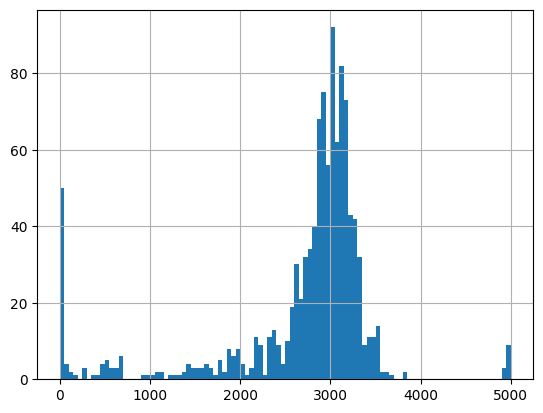

In [9]:
# This is the distribution of numbers of selected tokens per paper after cutting down
data['words per modified text'] = data['modified text'].apply(lambda x : len(x)) 
data['words per modified text'].hist(bins=100);

In [10]:
# Let's also exclude representations with less than 10 tokens
data = data[data['words per modified text'] > 9].reset_index().drop(columns=['index'], axis=1)
data.shape

(1042, 8)

#### Now we will clean our data some more by reducing the samples of uncommon targets.

## Taking Care of the Targets

In [11]:
# Let's check how our topics and subtopics are distributed
data['topic'].value_counts()

biology                  311
medicine                 260
chemistry                 89
psychology                85
computer science          79
physics                   41
materials science         36
environmental science     30
mathematics               29
business                  21
economics                 21
geology                   12
geography                  9
sociology                  8
engineering                6
political science          3
history                    2
Name: topic, dtype: int64

#### Topics are highly imballanced, we'll have to take care of this later.

In [12]:
# Now checking the counts of the subtopics
data['subtopic'].value_counts()

internal medicine         66
cell biology              60
neuroscience              48
immunology                46
genetics                  45
                          ..
agricultural economics     1
engineering ethics         1
organic chemistry          1
biotechnology              1
electronic engineering     1
Name: subtopic, Length: 178, dtype: int64

In [13]:
# Inspecting the relationship between topics and subtopics
data.groupby(by=['topic', 'subtopic']).count()

id  title  text  total words per text  \
topic     subtopic                                                         
biology   agroforestry              2      2     2                     2   
          algorithm                 1      1     1                     1   
          anatomy                   4      4     4                     4   
          archaeology               1      1     1                     1   
          biochemical engineering   1      1     1                     1   
...                                ..    ...   ...                   ...   
sociology law and economics         1      1     1                     1   
          management science        1      1     1                     1   
          public relations          1      1     1                     1   
          social psychology         1      1     1                     1   
          social science            2      2     2                     2   

                                   modified text  words per modified text  
topic     subtopic                                                         
biology   agroforestry                         2                        2  
          algorithm                            1                        1  
          anatomy                              4                        4  
          archaeology                          1                        1  
          biochemical engineering              1                        1  
...                                          ...                      ...  
sociology law and economics                    1                        1  
          management science                   1                        1  
          public relations                     1                        1  
          social psychology                    1                        1  
          social science                       2                        2  

[326 rows x 6 columns]

In [14]:
# Remark on the subtopics
num_subtopics = len(data['subtopic'].value_counts())
num_subtopics_grouped_by_topics = len(data.groupby(by=['topic', 'subtopic']).count())

print(f'Since the number of subtopics is {num_subtopics} and the number subtopics grouped by their topics increases to {num_subtopics_grouped_by_topics}, we can deduce, that we have subtopics, that belong to several academic fields.')

Since the number of subtopics is 178 and the number subtopics grouped by their topics increases to 326, we can deduce, that we have subtopics, that belong to several academic fields.


#### Which are these? And how common are those multiclass subtopics?

In [15]:
# Getting the subtopics that are attributed to several topics
def finding_multiassigned_subtopics():
    list_of_multiclass_subtopics = []
    for i in range(len(data.groupby(by=['subtopic', 'topic']).count())-1):
        if (data.groupby(by=['subtopic', 'topic']).count().index[i][0] == \
            data.groupby(by=['subtopic', 'topic']).count().index[i+1][0]):
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i])
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i+1])

    return list(set(list_of_multiclass_subtopics))

In [16]:
# Which multiclass assigned subtopics are the most common ones?
multiclass_subtopics = finding_multiassigned_subtopics()

df = pd.DataFrame()
for i in range(len(multiclass_subtopics)):
    extracted_data = (data[(data['subtopic'] == multiclass_subtopics[i][0]) & (data['topic'] == multiclass_subtopics[i][1])])
    extracted_data_old = df
    df = pd.concat([extracted_data_old, extracted_data], ignore_index=True)
df = df.sort_values(by='subtopic')

df.groupby(by="subtopic").count().sort_values(by='id', ascending=False)

,id,title,text,topic,total words per text,modified text,words per modified text
subtopic,,,,,,,
internal medicine,66,66,66,66,66,66,66
cell biology,60,60,60,60,60,60,60
neuroscience,48,48,48,48,48,48,48
immunology,46,46,46,46,46,46,46
genetics,45,45,45,45,45,45,45
...,...,...,...,...,...,...,...
environmental economics,2,2,2,2,2,2,2
demographic economics,2,2,2,2,2,2,2
biomedical engineering,2,2,2,2,2,2,2


#### We can see that some interdisciplinary subtopics (those with high transfer potential) tend to live in several academic fields.

In [17]:
# example subtopic 'cell biology' 
df[df['subtopic'] == 'cell biology']['topic'].value_counts()

biology             44
chemistry           14
computer science     1
medicine             1
Name: topic, dtype: int64

### Getting rid of rare topics and subtopics

In [18]:
# Filtering for those topics that appear more commonly in our data        <----- percentile should maybe be adjusted
common_topics = (data['topic'].value_counts() > np.percentile(data['topic'].value_counts(), 25)) # topics until 25th percentile
filtered_topics = common_topics[common_topics == True].index
filtered_topics

Index(['biology', 'medicine', 'chemistry', 'psychology', 'computer science',
       'physics', 'materials science', 'environmental science', 'mathematics',
       'business', 'economics', 'geology'],
      dtype='object')

In [19]:
# Filtering for those subtopics that appear more commonly in our data     <----- should maybe be adjusted
common_subtopics = (data['subtopic'].value_counts() > data['subtopic'].value_counts().mean())
filtered_subtopics = common_subtopics[common_subtopics == True].index
filtered_subtopics

Index(['internal medicine', 'cell biology', 'neuroscience', 'immunology',
       'genetics', 'molecular biology', 'computational biology',
       'biochemistry', 'cancer research', 'nanotechnology', 'psychiatry',
       'gerontology', 'endocrinology', 'ecology', 'cardiology', 'surgery',
       'bioinformatics', 'pharmacology', 'biophysics', 'social psychology',
       'pathology', 'microbiology', 'physical therapy', 'clinical psychology',
       'astronomy', 'cognitive psychology', 'demography',
       'developmental psychology', 'intensive care medicine', 'botany',
       'anatomy', 'data science', 'chemical engineering',
       'evolutionary biology', 'family medicine', 'pure mathematics',
       'virology', 'gynecology', 'statistics', 'artificial intelligence',
       'quantum mechanics', 'econometrics', 'environmental health', 'oncology',
       'algorithm', 'computer vision', 'chemical physics',
       'environmental resource management', 'pediatrics'],
      dtype='object')

In [20]:
# Filtering data according to the topics and subtopics that are more common
data = data[data['subtopic'].isin(list(filtered_subtopics)) & data['topic'].isin(list(filtered_topics))]
data.shape

(764, 8)

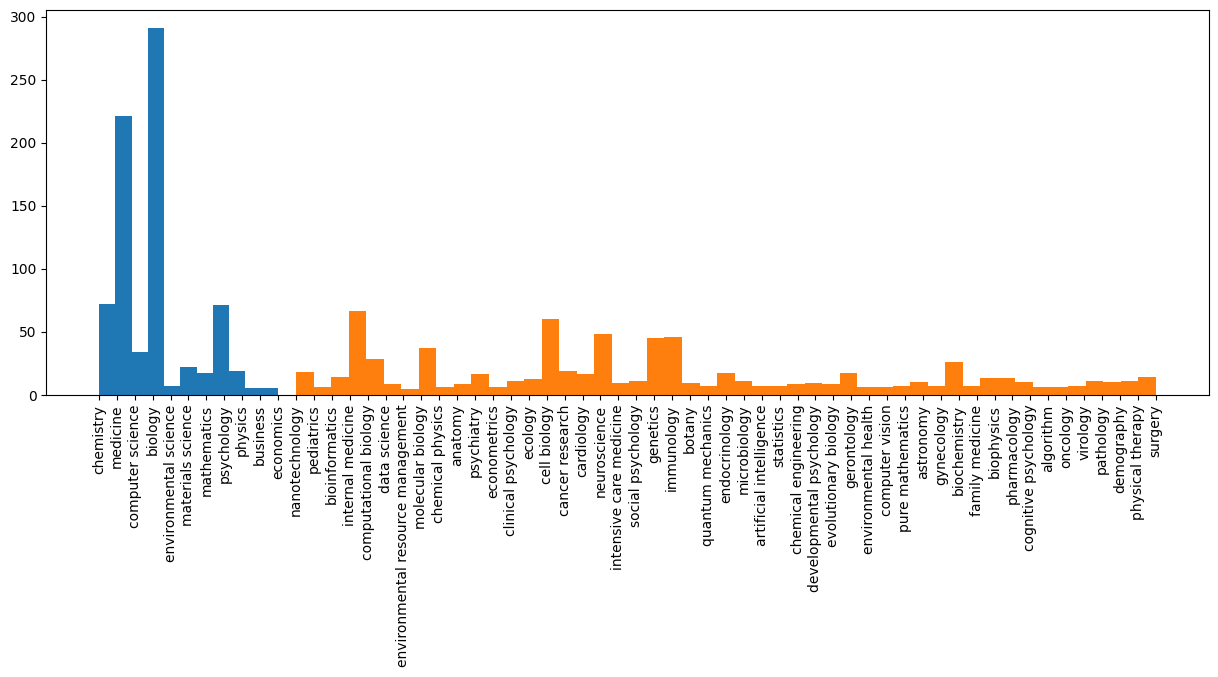

In [21]:
# The remaining topics and the subtopics are distributed as such:
plt.figure(figsize=(15, 5))
plt.hist(data['topic'], bins=data['topic'].nunique())
plt.hist(data['subtopic'], bins=data['subtopic'].nunique())
plt.xticks(rotation = 90)
plt.show()

In [22]:
# Printing precise number of occurances for each topic
print(Counter(data['topic']))

Counter({'biology': 291, 'medicine': 221, 'chemistry': 72, 'psychology': 71, 'computer science': 34, 'materials science': 22, 'physics': 19, 'mathematics': 17, 'environmental science': 7, 'business': 5, 'economics': 5})


#### The topics and subtopics are highly imbalanced still. They are our targets!!! So, we need to rebalance them (in the training set only) once we made our train-test.split.

#### Before though, based on this new shape of the dataframe, we will create word embeddings with Word2Vec!

### Word2Vec embedding of the text of the scientific papers

In [23]:
# Downloading a pre-trained model, based on a 50 space vector representation from Wikipedia
word2vec_transfer = api.load("glove-wiki-gigaword-50")
word2vec_transfer['saturn'].shape # checking the shape of the vectors: (50, )
print('Vocabulary size', len(word2vec_transfer))

Vocabulary size 400000


In [24]:
# Function to convert a paper (list of words) into a matrix representing the words in the embedding space
def embed_paper(word2vec_space, paper):
    embedded_paper = []
    for word in paper:
        if word in word2vec_space:
            embedded_paper.append(word2vec_space[word])
        
    return np.array(embedded_paper)

In [25]:
# Testing the function
test_sentence_embedded = embed_paper(word2vec_transfer, data['modified text'][0])
test_sentence_embedded.shape # some words have been skipped, because certainly they weren't contained in the glove-wiki-gigaword-50 representation

(2849, 50)

In [26]:
# Function to convert a list of papers into a list of matrices
def embedding(word2vec_space, series_of_papers):
    embed = []
    
    for ele in series_of_papers:
        embedded_article = embed_paper(word2vec_space, ele)
        embed.append(embedded_article)
        
    return embed

In [27]:
# Adding a column with embedded words from the papers into data frame
series_embedded = embedding(word2vec_transfer, data['modified text'])
data['embedded text'] = series_embedded
data.head()

,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,embedded text
0,https://openalex.org/w2100716186,large-scale screening of hypothetical metal-or...,published online november doi ...,chemistry,nanotechnology,38698,"[published, online, november, doi, nchem, arti...",2973,"[[-0.066601, 0.59438, -0.68071, -0.57313, -0.4..."
2,https://openalex.org/w2131625303,potassium channel antibody-associated encephal...,doi brain awh brain ...,medicine,pediatrics,59290,"[doi, brain, awh, brain, potassium, channel, a...",2944,"[[-0.65238, 0.048755, 1.0263, 0.93965, -1.4769..."
3,https://openalex.org/w2131736388,"modbase, a database of annotated comparative p...",d d nucleic acids research vol ...,computer science,bioinformatics,61704,"[nucleic, acids, research, vol, database, issu...",3100,"[[1.2364, -0.90471, -0.41702, -0.064745, 0.273..."
4,https://openalex.org/w2144966005,regional brain volume abnormalities and long-t...,original contribution regional brain volume a...,medicine,internal medicine,50244,"[original, contribution, regional, brain, volu...",3296,"[[0.36584, 0.47422, -0.26492, -0.11875, 0.1736..."
5,https://openalex.org/w2165253681,the intact molecular interaction database in 2012,published online november nucleic aci...,biology,computational biology,29340,"[published, online, november, nucleic, acids, ...",2612,"[[-0.066601, 0.59438, -0.68071, -0.57313, -0.4..."


In [28]:
# Padding all the embedded words
print(f'The embedding_size we had defined above is: {embedding_size}')
X_pad = pad_sequences(series_embedded, dtype='float32', padding='post', value=0, maxlen=embedding_size)

The embedding_size we had defined above is: 1000


### OneHot Encoding Targets

In [29]:
# OneHot Encoding topics
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
topic_targets_enc = pd.DataFrame(enc.fit_transform(data[['topic']]))
topic_targets_enc.columns = enc.get_feature_names_out()
topic_targets_enc

,topic_biology,topic_business,topic_chemistry,topic_computer science,topic_economics,topic_environmental science,topic_materials science,topic_mathematics,topic_medicine,topic_physics,topic_psychology
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Note to self: with <code>loss='sparse_categorical_crossentropy'</code> while compiling we don't need to OHE the target (which would alter the following process, but makes it more stable).

## RNN Model on Word2Vec pretrained vectors

In [30]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, topic_targets_enc, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(534, 1000, 50)
(534, 11)


#### The rebalancing due to strongly uneven distributed targets will be done by weighting each label's contribution to the cost function inversely proportional to the frequency of the label (since SMOTE doesn't seem to work on vectorized lists of words). 
#### The Keras model.fit() method has the hypterparameter class_weight that allows us to do this.

In [88]:
# Weighting the labels as a rebalancing technique (tool used: compute_class_weight())
y_integers = np.argmax(np.array(y_train), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.22474747474747475,
 1: 16.181818181818183,
 2: 0.9518716577540107,
 3: 2.206611570247934,
 4: 12.136363636363637,
 5: 12.136363636363637,
 6: 2.855614973262032,
 7: 4.045454545454546,
 8: 0.3172905525846702,
 9: 8.090909090909092,
 10: 1.0553359683794465}

#### With this dict, we will pass heigher weights for classes that are less present in our data set, that will be considered in the loss function. 
#### By doing this, we also increase the chance of overfitting to the rare labels, so we will also need to add a regularization.

In [90]:
# Defining Ridge Regularization
reg_l2 = regularizers.L2(0.01)

In [91]:
def init_model():
    model = Sequential()
    model.add(layers.Masking(input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(20, activation='relu', kernel_regularizer=reg_l2))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu', kernel_regularizer=reg_l2))
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [92]:
model = init_model()

In [93]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         (None, 1000, 50)          0         
                                                                 
 lstm_8 (LSTM)               (None, 20)                5680      
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dense_17 (Dense)            (None, 15)                315       
                                                                 
 dense_18 (Dense)            (None, 15)                240       
                                                                 
 dense_19 (Dense)            (None, 11)                176       
                                                                 
Total params: 6,831
Trainable params: 6,831
Non-traina

In [94]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    class_weight=d_class_weights,
          			batch_size=32,
         			epochs=100,
          			validation_split=0.3,
          			callbacks=[es])

Epoch 1/100
12/12 [==============================] - 7s 393ms/step - loss: 2.5306 - accuracy: 0.1099 - val_loss: 2.7198 - val_accuracy: 0.0621
Epoch 2/100
12/12 [==============================] - 3s 265ms/step - loss: 2.4951 - accuracy: 0.1126 - val_loss: 2.6973 - val_accuracy: 0.0621
Epoch 3/100
12/12 [==============================] - 3s 256ms/step - loss: 2.4657 - accuracy: 0.1126 - val_loss: 2.6745 - val_accuracy: 0.0621
Epoch 4/100
12/12 [==============================] - 3s 269ms/step - loss: 2.4380 - accuracy: 0.1126 - val_loss: 2.6477 - val_accuracy: 0.0621
Epoch 5/100
12/12 [==============================] - 3s 277ms/step - loss: 2.4106 - accuracy: 0.1126 - val_loss: 2.6262 - val_accuracy: 0.0621
Epoch 6/100
12/12 [==============================] - 3s 257ms/step - loss: 2.3823 - accuracy: 0.1126 - val_loss: 2.6083 - val_accuracy: 0.0621
Epoch 7/100
12/12 [==============================] - 3s 261ms/step - loss: 2.3570 - accuracy: 0.1126 - val_loss: 2.5946 - val_accuracy: 0.0621

In [95]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'The accuracy evaluated on the test set with inversely weighted targets is {res[1]*100:.3f}%')
print('The accuracy of the same model without inversely weighted targets was 43 %...')

The accuracy evaluated on the test set with inversely weighted targets is 8.261%
The accuracy of the same model without inversely weighted targets was 43 %...


#### Temporary comment: Adding two L2 regularization layers decreased the accuracy on the test set from 40 % to only 8 %!!! Need to do some research about that and experiment with Dropout layers.